In [1]:
# imports cell
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import warnings

# to create a tensor on the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

In [2]:
filename = "./dataset/icml_face_data.csv"

#emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [3]:
dataset_df = pd.read_csv(filename)
dataset_df

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


array([[<AxesSubplot:title={'center':'emotion'}>]], dtype=object)

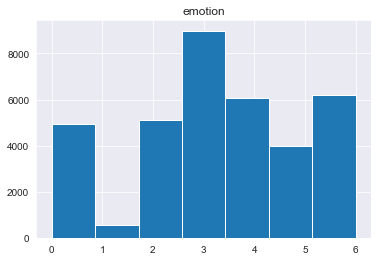

In [4]:
dataset_df.hist(column='emotion', bins=7)

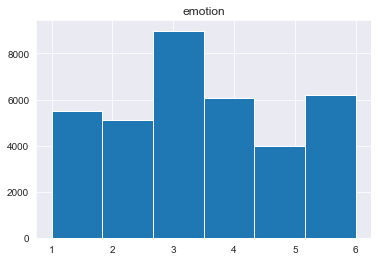

In [5]:
dataset_df['emotion'] = dataset_df['emotion'].replace(to_replace=0, value=1)
dataset_df.hist(column='emotion', bins=6)

emotions = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [6]:
def augment_data(data):
    image_array = np.zeros(shape=(len(data) * 4, 1, 48, 48))
    image_label = np.zeros(shape=(len(data) * 4, 1))

    j = 0
    for i in range(0,len(data) * 4,4):
        image_label[i] = data['emotion'].iloc[j]
        image = np.fromstring(data[' pixels'].iloc[j], dtype=int, sep=' ')
        image = np.reshape(image, (1, 48, 48))
        image_array[i] = image

        cv2.imwrite('img.png', image[0, :, :])
        img = cv2.imread('img.png', cv2.IMREAD_GRAYSCALE)

        rotate_right = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        image_array[i + 1] = rotate_right.reshape(1, 48, 48)
        image_label[i + 1] = image_label[i]

        rotate_left = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        image_array[i + 2] = rotate_left.reshape(1, 48, 48)
        image_label[i + 2] = image_label[i]

        # flip = cv2.flip(img, 0)
        # image_array[i + 3] = flip.reshape(1, 48, 48)
        # image_label[i + 3] = image_label[i]

        mirror = cv2.flip(img, 1)
        image_array[i + 3] = mirror.reshape(1, 48, 48)
        image_label[i + 3] = image_label[i]

        j+=1

    return image_array, image_label

def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 1, 48, 48))
    image_label = np.array(list(map(int, data['emotion']))).reshape(len(data), 1)

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (1, 48, 48))
        image_array[i] = image

    return image_array, image_label

In [7]:
x_train, y_train = augment_data(dataset_df[dataset_df[' Usage'] == 'Training'])
x_val, y_val = prepare_data(dataset_df[dataset_df[' Usage'] == 'PrivateTest'])
x_test, y_test = prepare_data(dataset_df[dataset_df[' Usage'] == 'PublicTest'])

In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((114836, 1, 48, 48),
 (114836, 1),
 (3589, 1, 48, 48),
 (3589, 1),
 (3589, 1, 48, 48),
 (3589, 1))

In [9]:
le = OneHotEncoder()
y_train = le.fit_transform(y_train).toarray()
y_val = le.fit_transform(y_val).toarray()
y_test = le.fit_transform(y_test).toarray()
y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

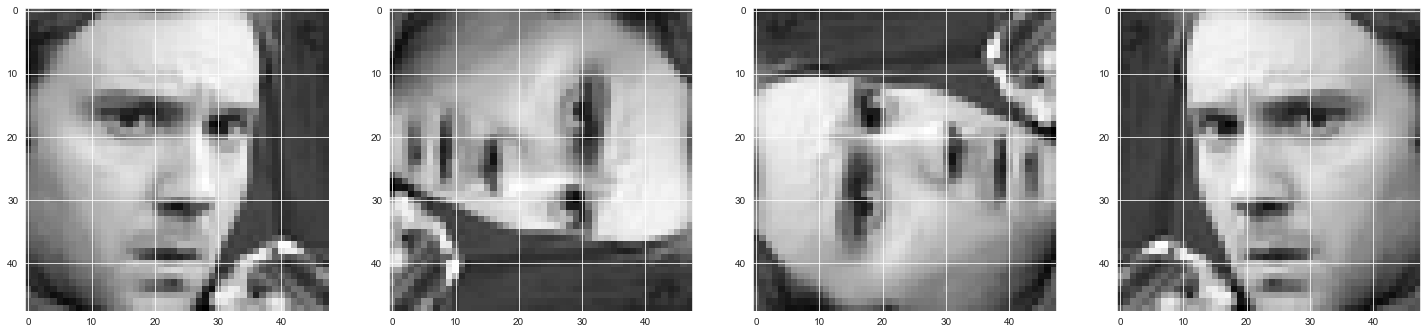

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(25, 12))
for i in range(4):
    axs[i].imshow(x_train[i][0, :, :], cmap='gray')

In [11]:
class MyDataset(Dataset):
    def __init__(self, array, labels):
        self.array = array
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.array[index], dtype=torch.float32, device=device), torch.tensor(self.labels[index],
                                                                                                 dtype=torch.float32,
                                                                                                 device=device)

    def __len__(self):
        return len(self.array)

In [12]:
trainDataset = MyDataset(x_train, y_train)

train_dataloader = DataLoader(trainDataset, batch_size=256, shuffle=True)

In [13]:
valDataset = MyDataset(x_val, y_val)

val_dataloader = DataLoader(valDataset, batch_size=256, shuffle=True)

In [14]:
testDataset = MyDataset(x_test, y_test)

test_dataloader = DataLoader(testDataset, batch_size=256, shuffle=True)

In [15]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # output size : (width - filter + 2*padding)/stride +1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('relu'))
        self.bn1 = nn.BatchNorm2d(num_features=8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('relu'))
        self.bn2 = nn.BatchNorm2d(num_features=16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv3.weight, gain=nn.init.calculate_gain('relu'))
        self.bn3 = nn.BatchNorm2d(num_features=32)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64800, 1024)  # dim c * w * h
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

        self.fc2 = nn.Linear(1024, 512)  # dim c * w * h
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

        self.fc3 = nn.Linear(512, 256)  # dim c * w * h
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

        self.fc4 = nn.Linear(256, 6)
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, data):
        data = self.conv1(data)
        data = F.relu(data)
        data = self.bn1(data)
        data = F.max_pool2d(data, kernel_size=2, stride=1)

        data = self.conv2(data)
        data = F.relu(data)
        data = self.bn2(data)
        data = F.max_pool2d(data, kernel_size=2, stride=1)

        data = self.conv3(data)
        data = F.relu(data)
        data = self.bn3(data)
        data = F.max_pool2d(data, kernel_size=2, stride=1)

        data = torch.flatten(data, 1)

        data = self.fc1(data)
        data = F.relu(data)

        data = self.dropout(data)

        data = self.fc2(data)
        data = F.relu(data)

        data = self.dropout(data)

        data = self.fc3(data)
        data = F.relu(data)

        data = self.dropout(data)

        data = self.fc4(data)

        return data

In [16]:
def train_model(model, dataloader, optimizer):
    model.train()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    for (data, label) in dataloader:
        # reset gradients (it will accumulate gradients otherwise)
        optimizer.zero_grad()

        # forward pass
        output = model(data)

        # compute loss
        loss_ = loss(output, label)
        total_loss += loss_.item()

        # backward propagation dl/dw -> gradients
        loss_.backward()

        # update weights
        optimizer.step()

        ######################################

        _, predicted = torch.max(output.data, dim=1)
        _, true_label = torch.max(label, dim=1)
        pred += predicted.tolist()
        labels += true_label.tolist()

    return accuracy_score(labels, pred) * 100., total_loss / len(dataloader)

In [17]:
def test_model(model, dataloader):
    model.eval()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for (data, label) in dataloader:
            output = model(data)

            # compute loss
            loss_ = loss(output, label)
            total_loss += loss_.item()

            _, predicted = torch.max(output.data, dim=1)
            _, true_label = torch.max(label, dim=1)
            pred += predicted.tolist()
            labels += true_label.tolist()

    return labels, pred, accuracy_score(labels, pred) * 100., total_loss / len(dataloader)

In [18]:
model_path = "./cnn_model.pth"

model = CNN_Model().to(device)

#model.load_state_dict(torch.load(model_path))

print('Number of Parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of Parameters :  67019894


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [20]:
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5, threshold=0.001)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
# chkpt = torch.load("./cnn_epoch10early_stop.pth")
# model.load_state_dict(chkpt['net_state'])
# optimizer.load_state_dict(chkpt['optimizer_state'])
# epoch_saved = chkpt['epoch'] + 1

In [22]:
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

In [23]:
epoch = 100
# Train and validate model

for e in range(epoch):
    train_accuracy, train_loss = train_model(model, train_dataloader, optimizer)

    val_labels, val_pred, val_accuracy, val_loss = test_model(model, val_dataloader)

    # Decay Learning Rate
    if e > 10:
        scheduler1.step(val_loss)
    else:
        scheduler2.step(e)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

    print('epoch: ', e + 1, 'Training loss: ', train_loss, 'Training Accuracy: ', train_accuracy, '%', '  Val loss: ',
          val_loss, 'Val Accuracy: ', val_accuracy, '%')
    print('learning rate :', optimizer.state_dict()['param_groups'][0]['lr'])

    # early stopping
    if train_accuracy - val_accuracy > 25:
        early_stop_path = "./cnn_epoch" + str(e) + "_early_stop.pth"
        info_dict = {
            'epoch': e,
            'net_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }
        torch.save(info_dict, early_stop_path)
        break

    # checkpoint
    if e % 5 == 0 and e > 0:
        early_stop_path = "./cnn_epoch" + str(e) + "_checkpoint.pth"
        info_dict = {
            'epoch': e,
            'net_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }
        torch.save(info_dict, early_stop_path)



epoch:  1 Training loss:  1.8489586592782579 Training Accuracy:  24.480998989863807 %   Val loss:  1.587235720952352 Val Accuracy:  31.401504597380885 %
learning rate : 0.001
epoch:  2 Training loss:  1.6106947469286506 Training Accuracy:  32.393151973248806 %   Val loss:  1.4486128250757853 Val Accuracy:  43.18751741432153 %
learning rate : 0.001
epoch:  3 Training loss:  1.4950720586861692 Training Accuracy:  38.56804486397994 %   Val loss:  1.4066760222117105 Val Accuracy:  44.05126776260797 %
learning rate : 0.001
epoch:  4 Training loss:  1.4170398138679217 Training Accuracy:  42.435299035145775 %   Val loss:  1.3573585192362467 Val Accuracy:  46.976873780997494 %
learning rate : 0.001
epoch:  5 Training loss:  1.3447482362887375 Training Accuracy:  45.957713608972796 %   Val loss:  1.2710504055023193 Val Accuracy:  51.3234884368905 %
learning rate : 0.001
epoch:  6 Training loss:  1.2680717980144816 Training Accuracy:  49.57156292451844 %   Val loss:  1.2712282339731853 Val Accur

Test loss:  1.4666029532750449 Test Accuracy:  54.58344942881025 %


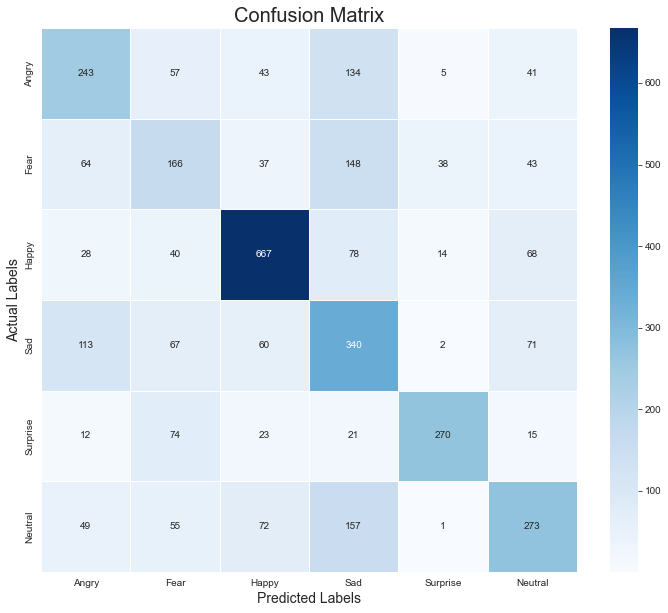

In [24]:
# test model

test_labels, test_pred, test_accuracy, test_loss = test_model(model, test_dataloader)
print('Test loss: ', test_loss, 'Test Accuracy: ', test_accuracy, '%')

cm = confusion_matrix(test_labels, test_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=emotions, columns=emotions)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [25]:
#torch.save(model.state_dict(), model_path)

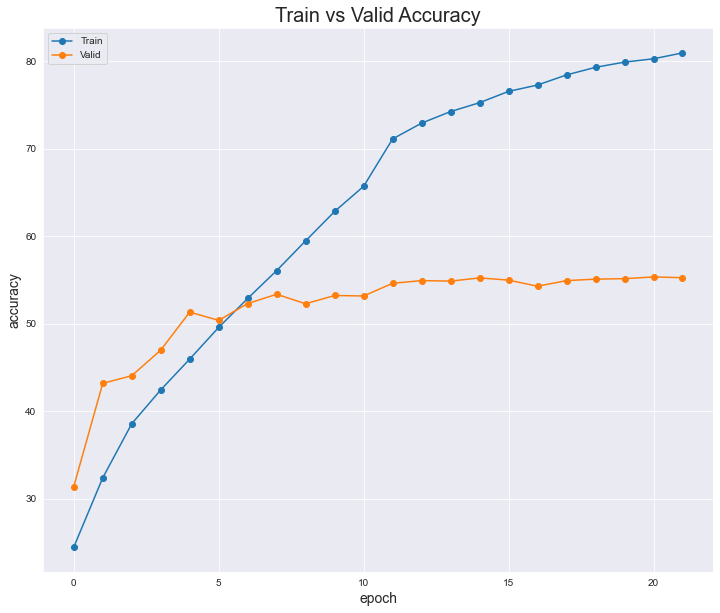

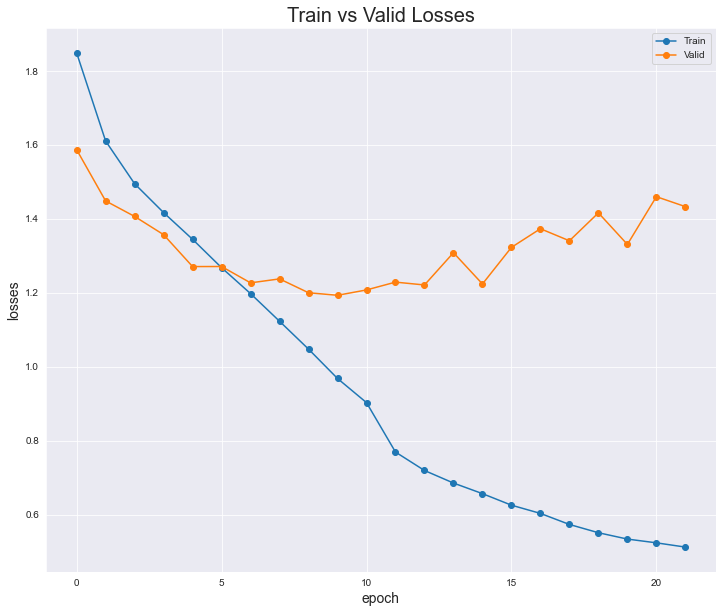

In [26]:
plt.figure(figsize=(12, 10))
plt.plot(train_acc_list, '-o')
plt.plot(val_acc_list, '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('accuracy', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy', size=20)

plt.show()

plt.figure(figsize=(12, 10))
plt.plot(train_loss_list, '-o')
plt.plot(val_loss_list, '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('losses', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses', size=20)

plt.show()